In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from the .pkl file
def load_data(pkl_file):
    return pd.read_pickle(pkl_file)['df']

# Compute the center of mass (COM) for each unique (rep, ratio, experiment, n_cells, t)
def calculate_com_and_distances(data):
    com_distances = []
    unique_groups = data.groupby(['rep', 'ratio', 'experiment', 'n_cells', 't'])

    for (rep, ratio, experiment, n_cells, t), subset in unique_groups:
        # Calculate the COM using the weighted average of (x, y, z) coordinates with volumes as weights
        total_volume = subset['v'].sum()
        com_x = (subset['x'] * subset['v']).sum() / total_volume
        com_y = (subset['y'] * subset['v']).sum() / total_volume
        com_z = (subset['z'] * subset['v']).sum() / total_volume

        # Calculate the distance of each cell from the COM
        subset = subset.copy()
        subset['distance_from_cm'] = np.sqrt(
            (subset['x'] - com_x)**2 + (subset['y'] - com_y)**2 + (subset['z'] - com_z)**2
        )

        com_distances.append(subset)

    # Combine the updated subsets back into a single DataFrame
    return pd.concat(com_distances, ignore_index=True)

# Calculate the mean distance from COM for each group (blue, green, yellow) and replicate
#### FOR INDUCED ONLY ####
def calculate_mean_distance_per_group(data,exp):
    mean_distances = []
    unique_groups = data.groupby(['rep', 'ratio', 'experiment', 'n_cells', 't'])
    if exp=='induced':
        for (rep, ratio, experiment, n_cells, t), subset in unique_groups:
            # Define the three groups based on the given criteria
            # induced
            A_cells = subset[(subset['cell_type'] == 'A') ]
            yellow_cells = subset[(subset['cell_type'] == 'B') & (subset['GFP'] < 1000)]
            B_cells = subset[(subset['cell_type'] == 'B') & (subset['GFP'] > 1000)]

            if not A_cells.empty:
                mean_distances.append({
                    'rep': rep,
                    'ratio': ratio,
                    'experiment': experiment,
                    'n_cells': n_cells,
                    't': t,
                    'group': 'A cells',
                    'mean_distance_from_cm': A_cells['distance_from_cm'].mean()
                })
            if not B_cells.empty:
                mean_distances.append({
                    'rep': rep,
                    'ratio': ratio,
                    'experiment': experiment,
                    'n_cells': n_cells,
                    't': t,
                    'group': 'B cells',
                    'mean_distance_from_cm': B_cells['distance_from_cm'].mean()
                })
    elif exp=='constitutive':
        for (rep, ratio, experiment, n_cells, t), subset in unique_groups:
            # constitutive
            A_cells = subset[(subset['cell_type'] == 'A')]
            B_cells = subset[(subset['cell_type'] == 'B') & (subset['BFP'] > 300)]

            if not A_cells.empty:
                mean_distances.append({
                    'rep': rep,
                    'ratio': ratio,
                    'experiment': experiment,
                    'n_cells': n_cells,
                    't': t,
                    'group': 'A cells',
                    'mean_distance_from_cm': A_cells['distance_from_cm'].mean()
                })
            if not B_cells.empty:
                mean_distances.append({
                    'rep': rep,
                    'ratio': ratio,
                    'experiment': experiment,
                    'n_cells': n_cells,
                    't': t,
                    'group': 'B cells',
                    'mean_distance_from_cm': B_cells['distance_from_cm'].mean()
                })

    # Return the mean distances as a DataFrame
    return pd.DataFrame(mean_distances)


# File path to the .pkl file
pkl_file = "../data/data_parsed.pkl"

# Load the data
df = load_data(pkl_file)


df_induced = df[df.experiment=='induced']
# Calculate COM and distances
df_with_distances = calculate_com_and_distances(df_induced)
# Calculate mean distance from COM per group
induced_group_mean_distance_df = calculate_mean_distance_per_group(df_with_distances,exp='induced')


# df = df[df.experiment=='induced']
df_const = df[df.experiment=='constitutive']
# Calculate COM and distances
df_with_distances = calculate_com_and_distances(df_const)
# Calculate mean distance from COM per group
constitutive_group_mean_distance_df = calculate_mean_distance_per_group(df_with_distances,exp='constitutive')





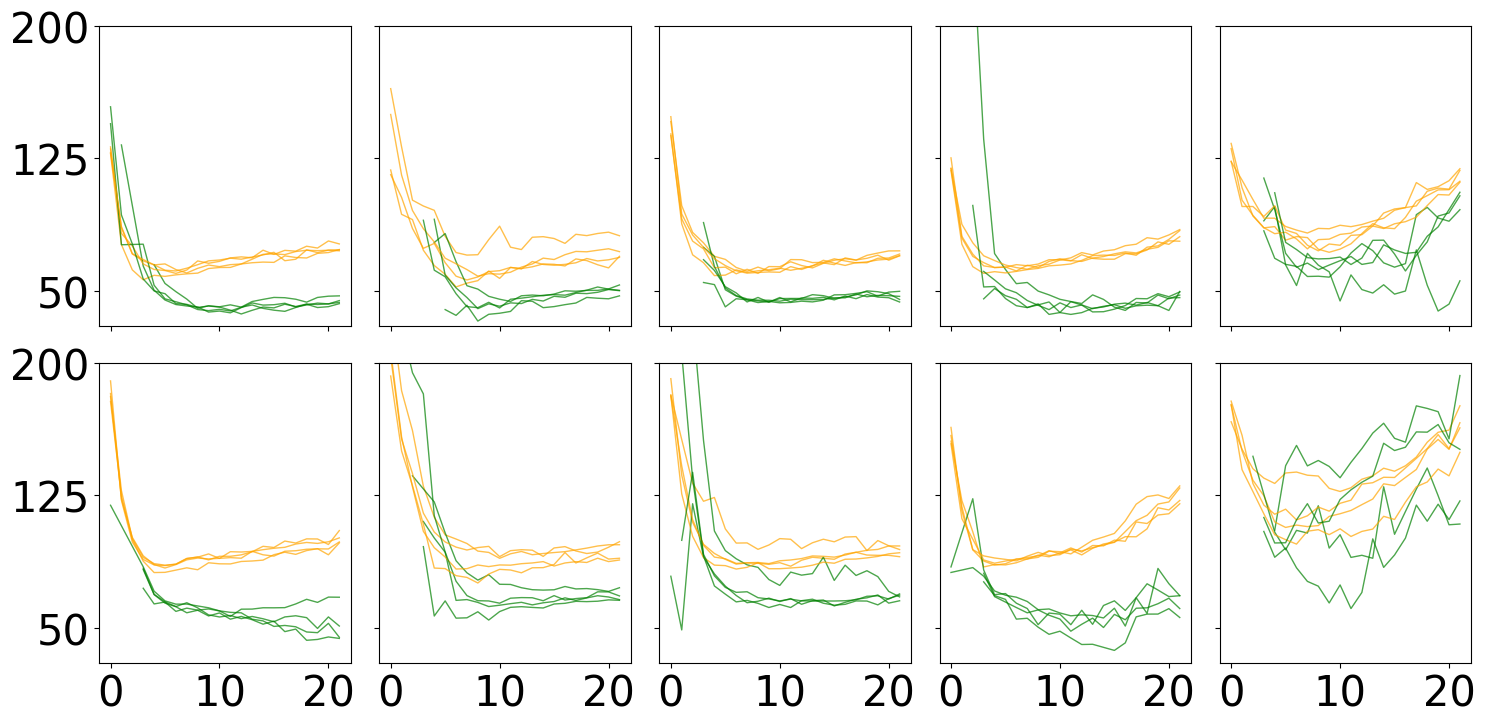

In [5]:
FONT_SCALE=3
# Plot the mean distance from COM by group
def plot_mean_distance(group_mean_distance_df, unique_n_cells, unique_ratios):
    fig, axes = plt.subplots(len(unique_n_cells), len(unique_ratios), figsize=(15, 8), sharex=True, sharey=True)

    for i, n_cells in enumerate(unique_n_cells):
        for j, ratio in enumerate(unique_ratios):
            # Filter data for the current (ratio, n_cells) combination
            subset = group_mean_distance_df[
                (group_mean_distance_df['n_cells'] == n_cells) & (group_mean_distance_df['ratio'] == ratio)
            ]

            # Plot the mean distance trajectories for each replicate and group
            for (rep, group), trajectory in subset.groupby(['rep', 'group']):
                color = 'orange' if group == 'A cells' else 'black' if group == 'yellow' else 'green'
                axes[i, j].plot(
                    trajectory['t'],
                    trajectory['mean_distance_from_cm'],
                    # label=f'{group.capitalize()} Rep {rep}',
                    color=color,
                    alpha=0.7,
                    lw=1
                )

    for ax in axes.flat:
        ax.set_ylim([30, 200])  # Replace min_value and max_value with your desired limits
        ax.set_yticks([50,125,200])
        ax.set_xticks([0,10,20])
        ax.tick_params(labelsize=10*FONT_SCALE)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Main script
# Define unique values for plotting
unique_n_cells = sorted(df['n_cells'].unique())
unique_ratios = sorted(df['ratio'].unique())
# Plot the results
plot_mean_distance(induced_group_mean_distance_df, unique_n_cells, unique_ratios)

final time: mean 99.1 std 28.2, color orange
final time: mean 67.4 std 31.7, color green


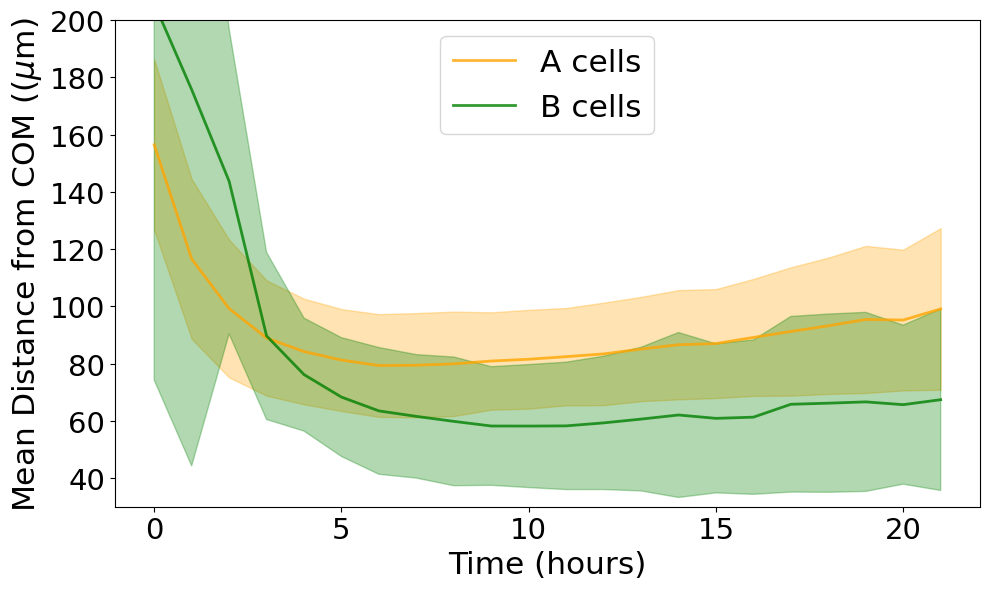

final time: mean 117.9 std 28.7, color orange
final time: mean 108.8 std 38.4, color green


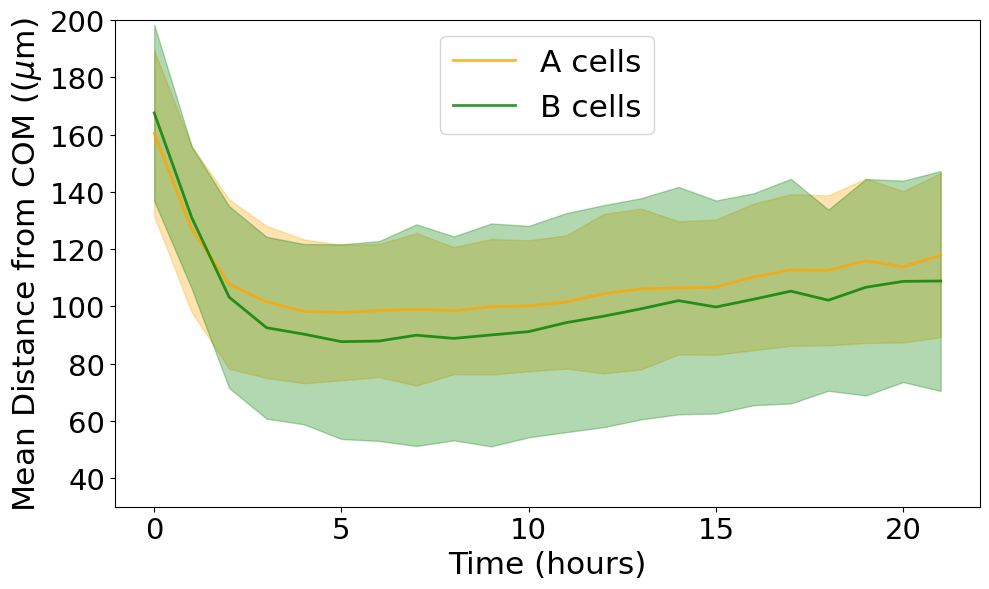

In [6]:
FONT_SCALE = 1.5
def plot_combined_mean_and_std(group_mean_distance_df):
    fig, ax = plt.subplots(figsize=(10, 6))
    # group_mean_distance_df = group_mean_distance_df[group_mean_distance_df.n_cells==300]

    for group, trajectory in group_mean_distance_df.groupby('group'):
        color = 'orange' if group == 'A cells' else 'black' if group == 'yellow' else 'green'
        mean_trajectory = trajectory.groupby('t')['mean_distance_from_cm'].mean()
        std_trajectory = trajectory.groupby('t')['mean_distance_from_cm'].std()
        time_points = mean_trajectory.index
        # print(color)
        ax.plot(
            time_points,
            mean_trajectory,
            label=f'{group.capitalize()}',
            color=color,
            alpha=0.8,
            lw=2
        )
        ax.fill_between(
            time_points,
            mean_trajectory - std_trajectory,
            mean_trajectory + std_trajectory,
            color=color,
            alpha=0.3,
            # label=f'{group.capitalize()} Std'
        )

        print(f'final time: mean {mean_trajectory[21]:0.1f} std {std_trajectory[21]:0.1f}, color {color}')

    # Labels and legend
    ax.set_xlabel('Time (hours)', fontsize=15*FONT_SCALE)
    ax.set_ylabel(r'Mean Distance from COM (($\mu$m)', fontsize=15*FONT_SCALE)
    # ax.set_title('Combined Mean and Std Trajectories of Cluster Distance from COM', fontsize=14)
    ax.legend(fontsize=15*FONT_SCALE, loc='upper center')
    ax.set_ylim([30,200])
    plt.yticks(fontsize=14*FONT_SCALE)
    plt.xticks(fontsize=14*FONT_SCALE)
    
    plt.tight_layout()
    plt.show()

plot_combined_mean_and_std(induced_group_mean_distance_df)
plot_combined_mean_and_std(constitutive_group_mean_distance_df)

/var/folders/1t/kt47yjvx78591gwn72kzzkgr0000gn/T/ipykernel_38256/475067439.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


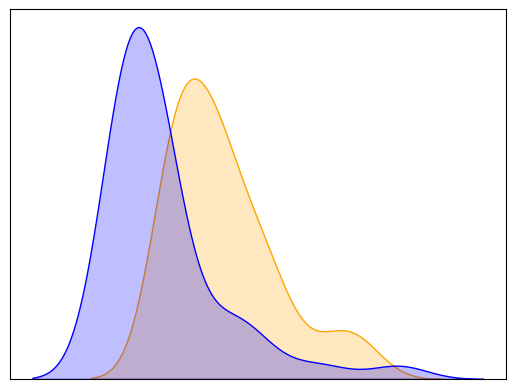

/var/folders/1t/kt47yjvx78591gwn72kzzkgr0000gn/T/ipykernel_38256/475067439.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


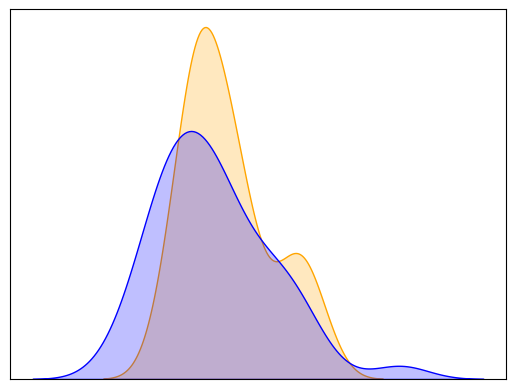

In [8]:
import seaborn as sns

def plot_distributions(group_mean_distance_df, final_time, font_scale):
    # Filter the data for A cells and B cells at the final time point
    a_cells_final_time = group_mean_distance_df[
        (group_mean_distance_df['group'] == 'A cells') & 
        (group_mean_distance_df['t'] == final_time)
    ]

    b_cells_final_time = group_mean_distance_df[
        (group_mean_distance_df['group'] == 'B cells') & 
        (group_mean_distance_df['t'] == final_time)
    ]

    # Plot the distributions
    plt.figure()
    sns.kdeplot(a_cells_final_time['mean_distance_from_cm'], color='orange', fill=True)
    sns.kdeplot(b_cells_final_time['mean_distance_from_cm'], color='blue', fill=True)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('')
    plt.ylabel('')
    plt.title('')
    plt.legend().set_visible(False)
    plt.show()

# Run the function for 'induced_group_mean_distance_df' and 'constitutive_group_mean_distance_df'
final_time=21
plot_distributions(induced_group_mean_distance_df, final_time, FONT_SCALE)
plot_distributions(constitutive_group_mean_distance_df, final_time, FONT_SCALE)

Made changes.

In [9]:

def compute_time_to_stabilize(df):
    # Filtering for "B cells"
    df = df[df["group"] == "B cells"]
    b_cells_df = df[df["n_cells"] == 900]

    # Calculate the first timepoint t for each unique trial where the mean_distance_from_cm is within 10% of the final mean_distance_from_cm
    result = []
    for _, group in b_cells_df.groupby(["rep", "ratio", "experiment", "n_cells"]):
        final_mean_distance = group["mean_distance_from_cm"].iloc[-1]
        threshold = final_mean_distance * 1.10
        first_t_within_threshold = group[group["mean_distance_from_cm"] <= threshold]["t"].min()
        result.append(first_t_within_threshold)

    # Calculate mean and standard deviation
    mean_t = pd.Series(result).mean()
    std_t = pd.Series(result).std()

    print(f'mean:{mean_t:0.1f}, std:{std_t:0.1f}')

compute_time_to_stabilize(df = constitutive_group_mean_distance_df)
compute_time_to_stabilize(df = induced_group_mean_distance_df)

mean:1.6, std:0.6
mean:6.3, std:4.5
